<a href="https://colab.research.google.com/github/sudipta-on/Quantum-Many-Body-Problem-using-Netket/blob/main/Heisenberg_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $$\textbf{Ground-State: Heisenberg model}$$

$\qquad \qquad \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad \text{ - Sudipta Majumder}$

$4 $ $\text{July},2024$

The goal of is to review various neural network architectures available in NetKet, in order to learn the ground-state of a paradigmatic spin model: the spin-$1/2$ Heisenberg antiferromagnetic chain.

The Hamiltonian we will consider for this is the following

$$ H = \sum_{i=1}^{L} \vec{\sigma}_{i} \cdot \vec{\sigma}_{i+1}.$$

$L$ is the length of the chain, and we will use both open and periodic boundary conditions. $\vec{\sigma}=(\sigma^x,\sigma^y,\sigma^z)$ denotes  the vector of Pauli matrices. Please note that there is a factor of $2$ between Pauli-matrices and spin-1/2 operators (thus a factor of $4$ in $H$).

We will consider 5 possible ways of determining the ground-state of this model.

## 0. Installing Netket

If you are executing this notebook on Colab, you will need to install netket. You can do so by running the following cell:

In [1]:
!pip install --quiet netket

In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [3]:
# importing required modules
import netket as nk

import json
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib

%matplotlib inline
matplotlib.rc('font', family = 'Serif', size = 14)
matplotlib.rc('xtick', labelsize = 10)
matplotlib.rc('ytick', labelsize = 10)
matplotlib.rcParams['figure.figsize'] = (10,6)

## 1. Defining the Hamiltonian

NetKet covers quite a few standard Hamiltonians and lattices, so let's use this to quickly define the antiferromagnetic Heisenberg chain.
For the moment we assume $L=22$ and simply define a chain lattice in this way (using periodic boundary conditions for now).

In [4]:
# Define a 1d chain
L = 22
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

In [5]:
# Defining Hilbert Space
hi = nk.hilbert.Spin(s = 0.5, total_sz = 0, N = g.n_nodes)

In [6]:
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)

## 2. Exact Diagonalization

Just as a matter of future comparison, let's compute the exact ground-state energy (since this is still possible for $L=22$ using brute-force exact diagonalization).
NetKet provides wrappers to the Lanczos algorithm which we now use:

In [7]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

The exact ground-state energy is E0= -39.14752260706284


## 3. The Jastrow ansatz

Let's start with a simple ansatz for the ground-state: the Jastrow Ansatz.

$$ \log\psi(\sigma) = \sum_i a_i \sigma_i + \sum_{i,j} \sigma_i J_{i,j} \sigma_j $$

In [8]:
# J_model = Jastrow()
J_model = nk.models.Jastrow()
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic = True)

# The variational state
vs = nk.vqs.MCState(sa, J_model, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(600, out='Jastrow')
end = time.time()

jas_energy = vs.expect(ha)
jas_error = abs((jas_energy.mean - exact_gs_energy)/exact_gs_energy)
jas_time = end-start
print('### Jastrow calculation')
print('It Has',nk.jax.tree_size(vs.parameters),'parameters')
print('The Jastrow calculation took',jas_time,'seconds')
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {jas_error}")

/usr/local/lib/python3.10/dist-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### Jastrow calculation
It Has 231 parameters
The Jastrow calculation took 81.34704041481018 seconds
Optimized energy : -39.113+0.000j ± 0.014 [σ²=0.204, R̂=1.0064]
relative error   : 0.0008902081943071093


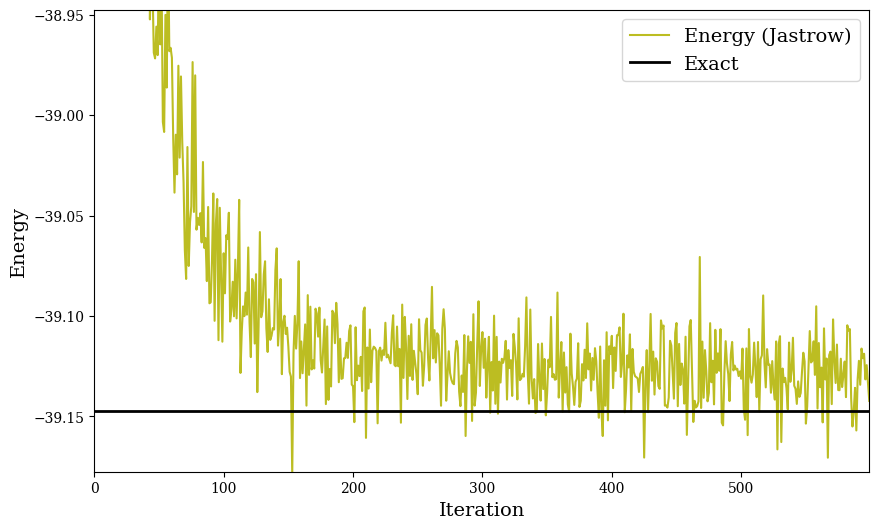

In [9]:
# import the data from log file
data_Jastrow=json.load(open("Jastrow.log"))
# Extract the relevant information
iters_Jastrow = data_Jastrow["Energy"]["iters"]
energy_Jastrow = data_Jastrow["Energy"]["Mean"]["real"]

plt.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
plt.ylabel('Energy')
plt.xlabel('Iteration')
plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_Jastrow[-1], linewidth=2, color='k', label='Exact')
plt.legend()
plt.show()

## 3. Restricted Boltzmann Machine (RBM)

We will now consider another celebrated ansatz, the Restricted Boltzmann Machine (RBM). It simply consists of two layers: a visible one representing the $L$ spin 1/2 degrees of freedom, and an hidden one which contains a different number $M$ of hidden units. There are connections between all visible and hidden nodes.

$\Psi_{\rm RBM} (\sigma_1^z,\sigma_2^z, ..., \sigma_L^z)  = \exp ( \sum_{i=1}^L a_i \sigma_i^z ) \prod_{i=1}^M \cosh (b_i + \sum_j W_{ij} \sigma^z_j)$

$a_i$ (resp. $b_i$) are the visible (resp. hidden) bias. Together with the weights $W_{ij}$, they are variational parameters that we (or rather NetKet) will optimize to minimize the energy. Netket gives you the control on the important parameters in this ansatz, such as $M$ and the fact that you want to use or not the biases.

More conveniently (especially if you want to try another $L$ in this tutorial), let's define the hidden unit density $\alpha = M / L$, and invoke the RBM ansatz in NetKet with as many hidden as visible units.

In [10]:
# RBM ansatz with alpha=1
ma = nk.models.RBM(alpha=1)

# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBM', n_iter=600)
end = time.time()

rbm_energy = vs.expect(ha)
rbm_error = abs((rbm_energy.mean - exact_gs_energy)/exact_gs_energy)
rbm_time = end-start
print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',rbm_time,'seconds')
print(f"Optimized energy : {rbm_energy}")
print(f"relative error   : {rbm_error}")

/usr/local/lib/python3.10/dist-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 528 parameters
The RBM calculation took 62.638498306274414 seconds
Optimized energy : -39.130 ± 0.014 [σ²=0.199, R̂=1.0084]
relative error   : 0.00043551693960512303


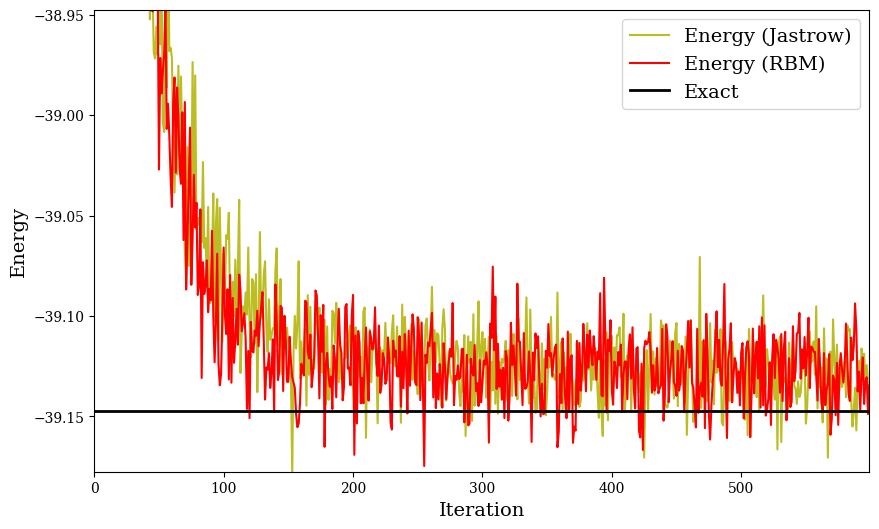

In [11]:
# import the data from log file
data=json.load(open("RBM.log"))

# Extract the relevant information
iters_RBM = data["Energy"]["iters"]
energy_RBM = data["Energy"]["Mean"]


plt.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
plt.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
plt.ylabel('Energy')
plt.xlabel('Iteration')
plt.axis([0,iters_RBM[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
plt.legend()
plt.show()

## 4. Using RBM with lattice symmetries

Let's define a similar RBM machine, which takes into account that the model has translational symmetries. All sites are equivalent and thus many of the wave-functions coefficients are related by symmetry. We use the same exact hyperparameters as in the previous RBM calculation ($\alpha=1$, same learning rate, and number of samples and iterations in the Variational Monte Carlo) and run now a symmetric RBM.

In [12]:
## Symmetric RBM Spin Machine
ma = nk.models.RBMSymm(symmetries=g.translation_group(), alpha=1)

# Metropolis Exchange Sampling
# Notice that this sampler exchanges two neighboring sites
# thus preservers the total magnetization
sa = nk.sampler.MetropolisExchange(hi, graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBMSymmetric', n_iter=600)
end = time.time()

symm_energy = vs.expect(ha)
symm_error = abs((symm_energy.mean - exact_gs_energy)/exact_gs_energy)
symm_time = end-start
print('### Symmetric RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The Symmetric RBM calculation took',symm_time,'seconds')
print(f"Optimized energy : {symm_energy}")
print(f"relative error   : {symm_error}")

/usr/local/lib/python3.10/dist-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### Symmetric RBM calculation
Has 24 parameters
The Symmetric RBM calculation took 54.65446853637695 seconds
Optimized energy : -39.127 ± 0.011 [σ²=0.125, R̂=1.0061]
relative error   : 0.0005293582353880769


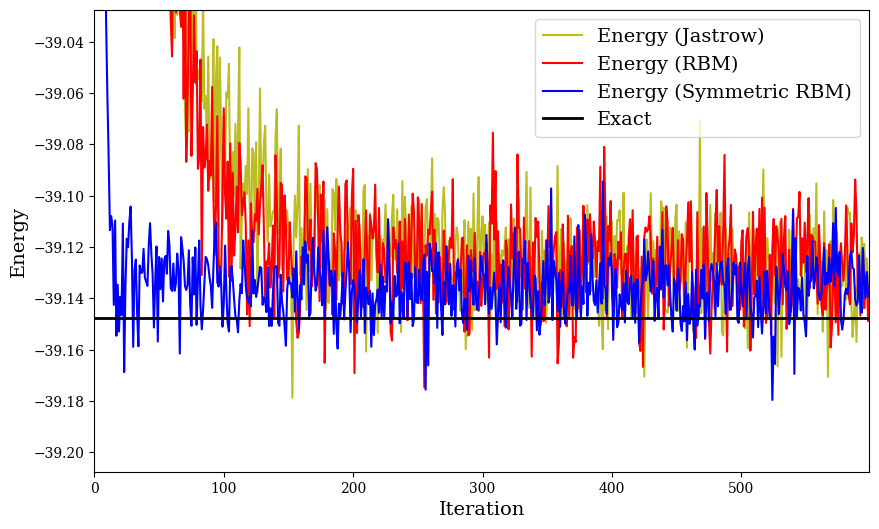

In [13]:
## import the data from log file
data=json.load(open("RBMSymmetric.log"))

# Extract the relevant information
iters_symRBM = data["Energy"]["iters"]
energy_symRBM = data["Energy"]["Mean"]

plt.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
plt.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
plt.plot(iters_symRBM, energy_symRBM, color='blue', label='Energy (Symmetric RBM)')

plt.ylabel('Energy')
plt.xlabel('Iteration')
if exact_gs_energy:
    plt.axis([0,iters_symRBM[-1],exact_gs_energy-0.06,exact_gs_energy+0.12])
    plt.axhline(y=exact_gs_energy, xmin=0,
                    xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
plt.legend()
plt.show()

## 5. Feed Forward Neural Networks

Now let's try a more complex network, namely a Feed Forward Neural Network (FFNN). There you will have more freedom to construct your own specific architecture. We'll try two different FFNN in this tutorial.

The first one is a simple structure: the first layer takes as input L-dimensional input, applies a bias and outputs two times more data, just followed by a `Lncosh` activation layer. The final layer `SumOutput` is needed to obtain a single number for the wave-function coefficient associated to the input basis state.


In [14]:
import netket.nn as nknn
import flax.linen as nn
import jax
import jax.numpy as jnp

class Model(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(
            features=2*x.shape[-1],
            param_dtype=np.complex128,
            kernel_init=nn.initializers.normal(stddev=0.1),
            bias_init=nn.initializers.normal(stddev=0.1))(x)
        x = nk.nn.activation.log_cosh(x)
        return jax.numpy.sum(x, axis=-1)

ffnn = Model()

sa = nk.sampler.MetropolisExchange(hi, graph=g)

# The variational state
vs = nk.vqs.MCState(sa, ffnn, n_samples=1000)

opt = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic = True)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)


start = time.time()
gs.run(out='FF', n_iter=300)
end = time.time()
ffn_energy = vs.expect(ha)
ffn_error = abs((ffn_energy.mean - exact_gs_energy)/exact_gs_energy)
ffn_time = end-start
print('### Feed Forward calculation')
print('Has',vs.n_parameters,'parameters')
print('The Feed Forward calculation took',ffn_time,'seconds')
print(f"Optimized energy : {ffn_energy}")
print(f"relative error   : {ffn_error}")


/usr/local/lib/python3.10/dist-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/300 [00:00<?, ?it/s]

### Feed Forward calculation
Has 1012 parameters
The Feed Forward calculation took 130.90205311775208 seconds
Optimized energy : -39.136+0.004j ± 0.019 [σ²=0.352, R̂=1.0041]
relative error   : 0.00031616436043029706


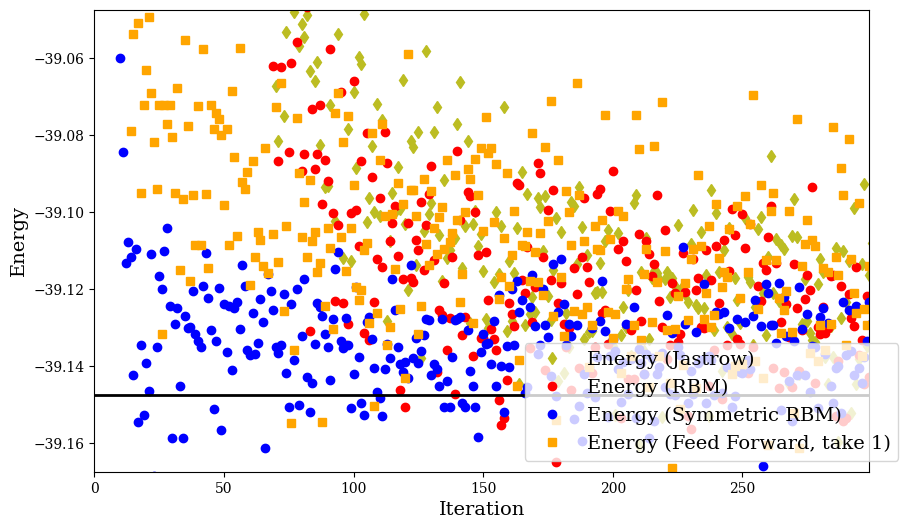

In [15]:
# import the data from log file
data=json.load(open("FF.log"))

# Extract the relevant information
iters_FF = data["Energy"]["iters"]
energy_FF = data["Energy"]["Mean"]["real"]


plt.plot(iters_Jastrow, energy_Jastrow, color='C8',linestyle="None", marker='d',label='Energy (Jastrow)')
plt.plot(iters_RBM, energy_RBM, color='red', marker='o',linestyle="None",label='Energy (RBM)')
plt.plot(iters_symRBM, energy_symRBM, color='blue',linestyle="None",marker='o',label='Energy (Symmetric RBM)')
plt.plot(iters_FF, energy_FF, color='orange', marker='s',linestyle="None",label='Energy (Feed Forward, take 1)')
plt.legend(bbox_to_anchor=(1.05, 0.3))
plt.ylabel('Energy')
plt.xlabel('Iteration')
plt.axis([0,iters_FF[-1],exact_gs_energy-0.02,exact_gs_energy+0.1])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
plt.show()

In [16]:
class Model2(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], param_dtype=np.complex128, kernel_init=nn.initializers.normal(stddev=0.1), bias_init=nn.initializers.normal(stddev=0.1))(x)
        x = nk.nn.activation.log_cosh(x)
        x = nn.Dense(features=x.shape[-1], param_dtype=np.complex128, kernel_init=nn.initializers.normal(stddev=0.1), bias_init=nn.initializers.normal(stddev=0.1))(x)
        x = nk.nn.activation.log_cosh(x)
        return jax.numpy.sum(x, axis=-1)

ffnn2 = Model2()

# The variational state
vs = nk.vqs.MCState(sa, ffnn, n_samples=1000)

opt = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic = True)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)


start = time.time()
gs.run(out='FF2', n_iter=600)
end = time.time()
ffn_energy2 = vs.expect(ha)
ffn_error2 = abs((ffn_energy2.mean - exact_gs_energy)/exact_gs_energy)
ffn_time2 = end-start


print('### Feed Forward (more layers) calculation')
print('Has',vs.n_parameters,'parameters')
print('The Feed Forward (more layers) calculation took',ffn_energy2,'seconds')
print(f"Optimized energy : {ffn_energy2}")
print(f"relative error   : {ffn_error2}")

/usr/local/lib/python3.10/dist-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### Feed Forward (more layers) calculation
Has 1012 parameters
The Feed Forward (more layers) calculation took -39.153+0.003j ± 0.020 [σ²=0.387, R̂=1.0097] seconds
Optimized energy : -39.153+0.003j ± 0.020 [σ²=0.387, R̂=1.0097]
relative error   : 0.00015382965609599738


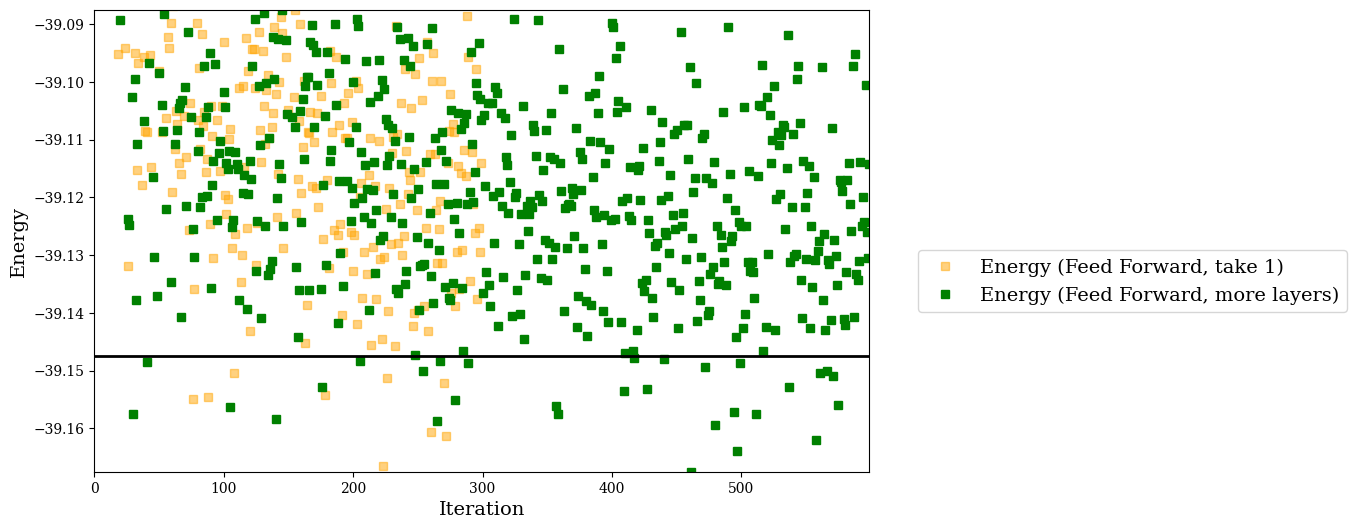

In [17]:
# import the data from log file
data=json.load(open("FF2.log"))

# Extract the relevant information
iters_FF_morelayers = data["Energy"]["iters"]
energy_FF_morelayers = data["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_FF, energy_FF, color='orange', marker='s',alpha=0.5,linestyle="None",label='Energy (Feed Forward, take 1)')
ax1.plot(iters_FF_morelayers, energy_FF_morelayers, color='green',marker='s',linestyle="None", alpha=1,label='Energy (Feed Forward, more layers)')
ax1.legend(bbox_to_anchor=(1.05, 0.5))
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_RBM[-1],exact_gs_energy-0.02,exact_gs_energy+0.06])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
plt.show()

## 6. Comparing Runtime and Relative error for same number of iteration
Now let us compare time required for different methods/ ansatz for same number of iterations (n = 300).



In [18]:
print("Time Required for Different methods/ ansatz for same number of iteration")
print("------------------------------------------------------------------")
print(f"Jastrow   : {jas_time} seconds")
print(f"FFN       : {ffn_time} seconds")
print(f"RBM       : {rbm_time} seconds")
print(f"SymmModel : {symm_time} seconds")
print("------------------------------------------------------------------")

Time Required for Different methods/ ansatz for same number of iteration
------------------------------------------------------------------
Jastrow   : 81.34704041481018 seconds
FFN       : 130.90205311775208 seconds
RBM       : 62.638498306274414 seconds
SymmModel : 54.65446853637695 seconds
------------------------------------------------------------------


In [19]:
print("Relative error for Different methods/ ansatz for same number of iteration")
print("------------------------------------------------------------------")
print(f"Jastrow   : {jas_error}")
print(f"FFN       : {ffn_error}")
print(f"RBM       : {rbm_error}")
print(f"SymmModel : {symm_error}")
print("------------------------------------------------------------------")

Relative error for Different methods/ ansatz for same number of iteration
------------------------------------------------------------------
Jastrow   : 0.0008902081943071093
FFN       : 0.00031616436043029706
RBM       : 0.00043551693960512303
SymmModel : 0.0005293582353880769
------------------------------------------------------------------
